In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')
rcParams['figure.figsize'] = (12, 9)

# 讀取資料

In [2]:
train = pd.read_csv('data/train.csv',parse_dates = ['date'], index_col = 'id')
event = pd.read_csv('data/holidays_events.csv',parse_dates = ['date'])
stores=pd.read_csv('data/stores.csv', index_col = 'store_nbr')
weekday=pd.read_csv('data/weekday.csv')
test=pd.read_csv('data/test.csv',parse_dates = ['date'], index_col = 'id')
submission=pd.read_csv('data/sample_submission.csv')
orig_oil = pd.read_csv("data/oil.csv", parse_dates=['date'])

# 資料前處理

* 將train及test一起處理

In [3]:
train = train.loc[train["date"] >= pd.to_datetime('2016-06-01')]
print(train.shape,test.shape)
train=pd.concat([train,test],axis=0)    
print(train.shape)
train

(784080, 5) (28512, 4)
(812592, 5)


,date,store_nbr,family,sales,onpromotion
id,,,,,
2216808,2016-06-01,1,AUTOMOTIVE,3.0,0
2216809,2016-06-01,1,BABY CARE,0.0,0
2216810,2016-06-01,1,BEAUTY,4.0,0
2216811,2016-06-01,1,BEVERAGES,2199.0,37
2216812,2016-06-01,1,BOOKS,0.0,0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1


In [4]:
national_event = event.loc[(event["locale"] == 'National') & (event["transferred"] == False)]
national_event.drop_duplicates(subset=["date"], inplace=True)
local_event = event.loc[(event["locale"] != 'National') & (event["transferred"] == False)]
data=train.merge(national_event,how='left',on='date').set_index(train.index)
data["local_type"] = np.nan


In [5]:

data[["city", "state","store_type", "store_cluster"]] = np.nan
for id in stores.index:
    data.loc[data["store_nbr"] == id,["city","state","store_type", "store_cluster"]] = stores.loc[id,["city","state","type", "cluster"]].to_list()
data

'''
data[["city", "state"]] = np.nan
for id in stores.index:
    data.loc[data["store_nbr"] == id,["city","state"]] = stores.loc[id,["city","state"]].to_list()
data
'''

'\ndata[["city", "state"]] = np.nan\nfor id in stores.index:\n    data.loc[data["store_nbr"] == id,["city","state"]] = stores.loc[id,["city","state"]].to_list()\ndata\n'

In [6]:


for id in local_event.index:
    #print(id)
    data.loc[(data["date"] == local_event.at[id,"date"]) 
    & ((data["city"] == local_event.at[id,"locale_name"]) 
    | (data["state"] == local_event.at[id,"locale_name"]) ),"local_type"] = local_event.at[id, "type"]
print(data.shape)


(812592, 15)


In [7]:
data.loc[data["local_type"].isna() == False]

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state,store_type,store_cluster
id,,,,,,,,,,,,,,,
2256342,2016-06-23,19,AUTOMOTIVE,3.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Guaranda,Bolivar,C,15.0
2256343,2016-06-23,19,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Guaranda,Bolivar,C,15.0
2256344,2016-06-23,19,BEAUTY,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Guaranda,Bolivar,C,15.0
2256345,2016-06-23,19,BEVERAGES,1270.0,3,NaN,NaN,NaN,NaN,NaN,Holiday,Guaranda,Bolivar,C,15.0
2256346,2016-06-23,19,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,Holiday,Guaranda,Bolivar,C,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016657,2017-08-24,50,POULTRY,NaN,0,NaN,NaN,NaN,NaN,NaN,Holiday,Ambato,Tungurahua,A,14.0
3016658,2017-08-24,50,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,Holiday,Ambato,Tungurahua,A,14.0
3016659,2017-08-24,50,PRODUCE,NaN,2,NaN,NaN,NaN,NaN,NaN,Holiday,Ambato,Tungurahua,A,14.0


In [8]:
train

,date,store_nbr,family,sales,onpromotion
id,,,,,
2216808,2016-06-01,1,AUTOMOTIVE,3.0,0
2216809,2016-06-01,1,BABY CARE,0.0,0
2216810,2016-06-01,1,BEAUTY,4.0,0
2216811,2016-06-01,1,BEVERAGES,2199.0,37
2216812,2016-06-01,1,BOOKS,0.0,0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1


In [9]:
data

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state,store_type,store_cluster
id,,,,,,,,,,,,,,,
2216808,2016-06-01,1,AUTOMOTIVE,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0
2216809,2016-06-01,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0
2216810,2016-06-01,1,BEAUTY,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0
2216811,2016-06-01,1,BEVERAGES,2199.0,37,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0
2216812,2016-06-01,1,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0


* 增加星期幾的feature

In [10]:

#data["weeday"] = data["date"].dt.weekday
#weekday = pd.get_dummies(data["date"].dt.weekday, prefix='weekday')
data["weekday"] = data["date"].dt.weekday
data["is_weekend"] = data["weekday"].copy()

In [11]:
data.loc[data["weekday"] < 5,"is_weekend"]= 0
data.loc[data["weekday"] >= 5, "is_weekend"] = 1
data

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state,store_type,store_cluster,weekday,is_weekend
id,,,,,,,,,,,,,,,,,
2216808,2016-06-01,1,AUTOMOTIVE,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0
2216809,2016-06-01,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0
2216810,2016-06-01,1,BEAUTY,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0
2216811,2016-06-01,1,BEVERAGES,2199.0,37,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0
2216812,2016-06-01,1,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0,3,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0,3,0
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0,3,0


In [12]:
'''
day = pd.get_dummies(data["date"].dt.day, prefix='day') 
month = pd.get_dummies(data["date"].dt.month, prefix='month')
year = pd.get_dummies(data["date"].dt.year, prefix='year')
'''
day = data["date"].dt.day.rename('day')
month = data["date"].dt.month.rename('month')
year = data["date"].dt.year.rename('year')
data = pd.concat([data,year,month,day],axis=1)
data

,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,local_type,city,state,store_type,store_cluster,weekday,is_weekend,year,month,day
id,,,,,,,,,,,,,,,,,,,,
2216808,2016-06-01,1,AUTOMOTIVE,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216809,2016-06-01,1,BABY CARE,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216810,2016-06-01,1,BEAUTY,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216811,2016-06-01,1,BEVERAGES,2199.0,37,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216812,2016-06-01,1,BOOKS,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0,3,0,2017,8,31
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0,3,0,2017,8,31
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6.0,3,0,2017,8,31


* 將日期是否為各類events做one hot encode

In [13]:
"""
Holiday = pd.get_dummies(data.type, prefix='type')
data=data.drop(columns=['type','description','transferred','locale','locale_name'])
data=pd.concat([data,Holiday],axis=1)
data
local_Holiday = pd.get_dummies(data.local_type, prefix='local_type')
data=data.drop(columns=['local_type'])
data=pd.concat([data,local_Holiday],axis=1)
data
family=pd.get_dummies(data.family, prefix='family')
data=data.drop(columns=['family'])
data=pd.concat([data,family],axis=1)
data
store_nbr = pd.get_dummies(data.store_nbr, prefix='store_nbr')
data=data.drop(columns=['store_nbr'])
data=pd.concat([data,store_nbr],axis=1)
data
city = pd.get_dummies(data.city, prefix='city')
data=data.drop(columns=['city'])
data=pd.concat([data,city],axis=1)
data
state = pd.get_dummies(data.state, prefix='state')
data=data.drop(columns=['state'])
data=pd.concat([data,state],axis=1)
data
"""
data=data.drop(columns=['description','transferred','locale','locale_name'])
data

,date,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,weekday,is_weekend,year,month,day
id,,,,,,,,,,,,,,,,
2216808,2016-06-01,1,AUTOMOTIVE,3.0,0,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216809,2016-06-01,1,BABY CARE,0.0,0,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216810,2016-06-01,1,BEAUTY,4.0,0,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216811,2016-06-01,1,BEVERAGES,2199.0,37,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
2216812,2016-06-01,1,BOOKS,0.0,0,NaN,NaN,Quito,Pichincha,D,13.0,2,0,2016,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,Quito,Pichincha,B,6.0,3,0,2017,8,31
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,Quito,Pichincha,B,6.0,3,0,2017,8,31
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,Quito,Pichincha,B,6.0,3,0,2017,8,31


In [14]:
data['date']

id
2216808   2016-06-01
2216809   2016-06-01
2216810   2016-06-01
2216811   2016-06-01
2216812   2016-06-01
             ...    
3029395   2017-08-31
3029396   2017-08-31
3029397   2017-08-31
3029398   2017-08-31
3029399   2017-08-31
Name: date, Length: 812592, dtype: datetime64[ns]

In [15]:
orig_oil.set_index('date').resample("D").mean().isnull().sum()
df = orig_oil.copy()
    
# Adding missing values
df = df.set_index('date').resample("D").mean().interpolate(limit_direction='backward').reset_index()

# Adding new features
df['lagoil_1_dcoilwtico'] = df['dcoilwtico'].shift(1)
df['lagoil_2_dcoilwtico'] = df['dcoilwtico'].shift(2)
df['lagoil_3_dcoilwtico'] = df['dcoilwtico'].shift(3)
df['lagoil_4_dcoilwtico'] = df['dcoilwtico'].shift(4)
df['oil_week_avg'] = df['dcoilwtico'].rolling(7).mean()

df.dropna(inplace = True)
df.loc[df['date'].isin(data['date'])]

# Merging orig_oil and final_df
data = data.reset_index().merge(df.loc[df['date'].isin(data['date'])], on=['date'], how='left', validate="m:1").set_index('id')
data

,date,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
id,,,,,,,,,,,,,,,,,,,,,
2216808,2016-06-01,1,AUTOMOTIVE,3.0,0,NaN,NaN,Quito,Pichincha,D,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216809,2016-06-01,1,BABY CARE,0.0,0,NaN,NaN,Quito,Pichincha,D,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216810,2016-06-01,1,BEAUTY,4.0,0,NaN,NaN,Quito,Pichincha,D,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216811,2016-06-01,1,BEVERAGES,2199.0,37,NaN,NaN,Quito,Pichincha,D,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216812,2016-06-01,1,BOOKS,0.0,0,NaN,NaN,Quito,Pichincha,D,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,Quito,Pichincha,B,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,Quito,Pichincha,B,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714
3029397,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,Quito,Pichincha,B,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714


In [16]:
data.drop(data[(data['type'] == 'Event') ].index, inplace=True)
data.drop(["date"],axis='columns',inplace=True)
data

,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
id,,,,,,,,,,,,,,,,,,,,,
2216808,1,AUTOMOTIVE,3.0,0,NaN,NaN,Quito,Pichincha,D,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216809,1,BABY CARE,0.0,0,NaN,NaN,Quito,Pichincha,D,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216810,1,BEAUTY,4.0,0,NaN,NaN,Quito,Pichincha,D,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216811,1,BEVERAGES,2199.0,37,NaN,NaN,Quito,Pichincha,D,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216812,1,BOOKS,0.0,0,NaN,NaN,Quito,Pichincha,D,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,9,POULTRY,NaN,1,NaN,NaN,Quito,Pichincha,B,6.0,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714
3029396,9,PREPARED FOODS,NaN,0,NaN,NaN,Quito,Pichincha,B,6.0,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714
3029397,9,PRODUCE,NaN,1,NaN,NaN,Quito,Pichincha,B,6.0,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714


In [17]:
data.loc[data["local_type"].isna() == False]

,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
id,,,,,,,,,,,,,,,,,,,,,
2256342,19,AUTOMOTIVE,3.0,0,NaN,Holiday,Guaranda,Bolivar,C,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256343,19,BABY CARE,0.0,0,NaN,Holiday,Guaranda,Bolivar,C,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256344,19,BEAUTY,0.0,0,NaN,Holiday,Guaranda,Bolivar,C,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256345,19,BEVERAGES,1270.0,3,NaN,Holiday,Guaranda,Bolivar,C,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256346,19,BOOKS,0.0,0,NaN,Holiday,Guaranda,Bolivar,C,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016657,50,POULTRY,NaN,0,NaN,Holiday,Ambato,Tungurahua,A,14.0,...,0,2017,8,24,47.24,48.45,47.65,47.39,47.790000,47.900000
3016658,50,PREPARED FOODS,NaN,0,NaN,Holiday,Ambato,Tungurahua,A,14.0,...,0,2017,8,24,47.24,48.45,47.65,47.39,47.790000,47.900000
3016659,50,PRODUCE,NaN,2,NaN,Holiday,Ambato,Tungurahua,A,14.0,...,0,2017,8,24,47.24,48.45,47.65,47.39,47.790000,47.900000


In [18]:
from sklearn.preprocessing import LabelEncoder # 匯入 Label Encoder

le = LabelEncoder()                            

le.fit(data['family'])                         
data['family'] = le.transform(data['family'])  


In [19]:
le.fit(data['type'])                         
data['type'] = le.transform(data['type'])  


In [20]:
le.fit(data['city'])                         
data['city'] = le.transform(data['city'])  


In [21]:
le.fit(data['state'])                         
data['state'] = le.transform(data['state'])  


In [22]:
le.fit(data['store_type'])                         
data['store_type'] = le.transform(data['store_type'])  
data

,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
id,,,,,,,,,,,,,,,,,,,,,
2216808,1,0,3.0,0,5,NaN,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216809,1,1,0.0,0,5,NaN,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216810,1,2,4.0,0,5,NaN,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216811,1,3,2199.0,37,5,NaN,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
2216812,1,4,0.0,0,5,NaN,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165,49.23,49.295000,49.174286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,9,28,NaN,1,5,NaN,18,12,1,6.0,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714
3029396,9,29,NaN,0,5,NaN,18,12,1,6.0,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714
3029397,9,30,NaN,1,5,NaN,18,12,1,6.0,...,0,2017,8,31,47.26,45.96,46.460,46.40,46.816667,46.825714


In [23]:
data['local_type'].drop_duplicates()

id
2216808           NaN
2256342       Holiday
2311782      Transfer
2550042    Additional
Name: local_type, dtype: object

In [24]:
le.fit(data['local_type'].drop_duplicates())                         
data['local_type'] = le.transform(data['local_type'])  


In [25]:
data.loc[data['local_type'] != 3]

,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
id,,,,,,,,,,,,,,,,,,,,,
2256342,19,0,3.0,0,5,1,7,1,2,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256343,19,1,0.0,0,5,1,7,1,2,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256344,19,2,0.0,0,5,1,7,1,2,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256345,19,3,1270.0,3,5,1,7,1,2,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
2256346,19,4,0.0,0,5,1,7,1,2,15.0,...,0,2016,6,23,49.34,49.16,48.95,49.40,48.933333,48.892857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016657,50,28,NaN,0,5,1,0,15,0,14.0,...,0,2017,8,24,47.24,48.45,47.65,47.39,47.790000,47.900000
3016658,50,29,NaN,0,5,1,0,15,0,14.0,...,0,2017,8,24,47.24,48.45,47.65,47.39,47.790000,47.900000
3016659,50,30,NaN,2,5,1,0,15,0,14.0,...,0,2017,8,24,47.24,48.45,47.65,47.39,47.790000,47.900000


In [26]:
data.describe()

,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
count,807246.000000,807246.00000,778734.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,...,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000,807246.000000
mean,27.500000,16.00000,463.184523,6.628599,4.847682,2.989821,12.555556,8.796296,2.000000,8.481481,...,0.282561,2016.534216,6.596026,15.679912,48.334202,48.338688,48.346188,48.348653,48.358709,48.351672
std,15.585794,9.52191,1319.365375,18.243739,0.758310,0.154837,6.264740,4.165023,1.201851,4.649737,...,0.450245,0.498828,3.097773,8.806057,3.281451,3.282396,3.281660,3.282084,3.281800,3.176866
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,2016.000000,1.000000,1.000000,39.500000,39.500000,39.500000,39.500000,39.500000,40.658571
25%,14.000000,8.00000,3.000000,0.000000,5.000000,3.000000,8.000000,6.000000,1.000000,4.000000,...,0.000000,2016.000000,4.000000,8.000000,45.880000,45.860000,45.860000,45.860000,45.860000,45.957143
50%,27.500000,16.00000,25.000000,0.000000,5.000000,3.000000,14.000000,10.000000,2.000000,8.500000,...,0.000000,2017.000000,7.000000,16.000000,48.270000,48.300000,48.320000,48.340000,48.340000,48.158571
75%,41.000000,24.00000,265.096250,4.000000,5.000000,3.000000,18.000000,12.000000,3.000000,13.000000,...,1.000000,2017.000000,9.000000,23.000000,50.820000,50.820000,50.820000,50.820000,50.820000,50.540000
max,54.000000,32.00000,89576.360000,697.000000,5.000000,3.000000,21.000000,15.000000,4.000000,17.000000,...,1.000000,2017.000000,12.000000,31.000000,54.480000,54.480000,54.480000,54.480000,54.480000,54.051429


In [27]:
test=data.loc[(data.index >= 3000888)]

data=data.loc[(data.index < 3000888) ]

In [28]:
data

,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
id,,,,,,,,,,,,,,,,,,,,,
2216808,1,0,3.000,0,5,3,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165000,49.230000,49.295,49.174286
2216809,1,1,0.000,0,5,3,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165000,49.230000,49.295,49.174286
2216810,1,2,4.000,0,5,3,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165000,49.230000,49.295,49.174286
2216811,1,3,2199.000,37,5,3,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165000,49.230000,49.295,49.174286
2216812,1,4,0.000,0,5,3,18,12,3,13.0,...,0,2016,6,1,49.07,49.10,49.165000,49.230000,49.295,49.174286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,28,438.133,0,5,3,18,12,1,6.0,...,0,2017,8,15,47.57,47.59,47.996667,48.403333,48.810,48.357143
3000884,9,29,154.553,1,5,3,18,12,1,6.0,...,0,2017,8,15,47.57,47.59,47.996667,48.403333,48.810,48.357143
3000885,9,30,2419.729,148,5,3,18,12,1,6.0,...,0,2017,8,15,47.57,47.59,47.996667,48.403333,48.810,48.357143


In [29]:
test

,store_nbr,family,sales,onpromotion,type,local_type,city,state,store_type,store_cluster,...,is_weekend,year,month,day,dcoilwtico,lagoil_1_dcoilwtico,lagoil_2_dcoilwtico,lagoil_3_dcoilwtico,lagoil_4_dcoilwtico,oil_week_avg
id,,,,,,,,,,,,,,,,,,,,,
3000888,1,0,NaN,0,5,3,18,12,3,13.0,...,0,2017,8,16,46.80,47.57,47.59,47.996667,48.403333,47.958571
3000889,1,1,NaN,0,5,3,18,12,3,13.0,...,0,2017,8,16,46.80,47.57,47.59,47.996667,48.403333,47.958571
3000890,1,2,NaN,2,5,3,18,12,3,13.0,...,0,2017,8,16,46.80,47.57,47.59,47.996667,48.403333,47.958571
3000891,1,3,NaN,20,5,3,18,12,3,13.0,...,0,2017,8,16,46.80,47.57,47.59,47.996667,48.403333,47.958571
3000892,1,4,NaN,0,5,3,18,12,3,13.0,...,0,2017,8,16,46.80,47.57,47.59,47.996667,48.403333,47.958571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,9,28,NaN,1,5,3,18,12,1,6.0,...,0,2017,8,31,47.26,45.96,46.46,46.400000,46.816667,46.825714
3029396,9,29,NaN,0,5,3,18,12,1,6.0,...,0,2017,8,31,47.26,45.96,46.46,46.400000,46.816667,46.825714
3029397,9,30,NaN,1,5,3,18,12,1,6.0,...,0,2017,8,31,47.26,45.96,46.46,46.400000,46.816667,46.825714


In [30]:
'''
rcParams['figure.figsize'] = (120,90)
sns.heatmap(data.corr().abs(), vmin=0, annot = True, fmt='.2f', vmax=1, linewidths=.3)
'''

"\nrcParams['figure.figsize'] = (120,90)\nsns.heatmap(data.corr().abs(), vmin=0, annot = True, fmt='.2f', vmax=1, linewidths=.3)\n"

In [31]:


X = data.drop(['sales'],axis = 1)
y = data['sales']
y = np.log2(y+0.001)
y

id
2216808     1.585443
2216809    -9.965784
2216810     2.000361
2216811    11.102633
2216812    -9.965784
             ...    
3000883     8.775228
3000884     7.271967
3000885    11.240630
3000886     6.918875
3000887     4.000090
Name: sales, Length: 778734, dtype: float64

In [47]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as rmsle
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [34]:
test=test.drop(['sales'],axis = 1)


In [33]:
'''from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'max_depth': range(5,15,5), 
        'subsample' : np.arange(0.6,1.2,0.2),
        'learning_rate' : [0.1],
        'min_child_weight' : [1, 1.5, 2],
    }
]
grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='r2')
grid_search.fit(X, y)

'''

{'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1.5, 'subsample': 0.8}


ValueError: Feature shape mismatch, expected: 20, got 21

In [48]:
'''
print(grid_search.best_params_)
predict_RFR = grid_search.best_estimator_.predict(X_test)
predict_RFR_sub = grid_search.best_estimator_.predict(test)
'''

{'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1.5, 'subsample': 0.8}


In [49]:
#DTR = DecisionTreeRegressor(random_state = 42)

DTR = xgb.XGBRegressor(learning_rate= 0.1, max_depth= 10, min_child_weight= 1.5, subsample= 0.8)
DTR.fit(X, y)

predict_RFR = DTR.predict(X_test)
predict_RFR


predict_RFR_sub = DTR.predict(test)



'\nDTR = xgb.XGBRegressor(max_depth=9, subsample= 0.9)\nDTR.fit(X, y)\n\npredict_RFR = DTR.predict(X_test)\npredict_RFR\n\n\npredict_RFR_sub = DTR.predict(test)\n\n'

In [50]:
predict_RFR = np.power(2,predict_RFR)
predict_RFR
y_test = np.power(2,y_test)
print(f"RMSLE: {(rmsle(y_test, predict_RFR)):0.5f}")

RMSLE: 0.22001


In [51]:
predict_RFR_sub = np.power(2,predict_RFR_sub)

In [52]:
submission['sales'] = predict_RFR_sub
submission.to_csv('./submission.csv', index = False)
submission.head(10)

,id,sales
0,3000888,3.732604
1,3000889,0.001230
2,3000890,5.604635
3,3000891,2089.784668
4,3000892,0.002826
5,3000893,469.846344
6,3000894,10.998503
7,3000895,851.783264
8,3000896,797.360168
9,3000897,266.173462


In [53]:
test2=pd.read_csv('data/test.csv',parse_dates = ['date'], index_col = 'id')

In [54]:
import seaborn as sb

temp = submission.copy()
temp=temp.set_index("id")
temp[["date"]] = test2[["date"]]
temp = temp.set_index("date")
temp

,sales
date,
2017-08-16,3.732604
2017-08-16,0.001230
2017-08-16,5.604635
2017-08-16,2089.784668
2017-08-16,0.002826
...,...
2017-08-31,361.442535
2017-08-31,98.011337
2017-08-31,1074.584961


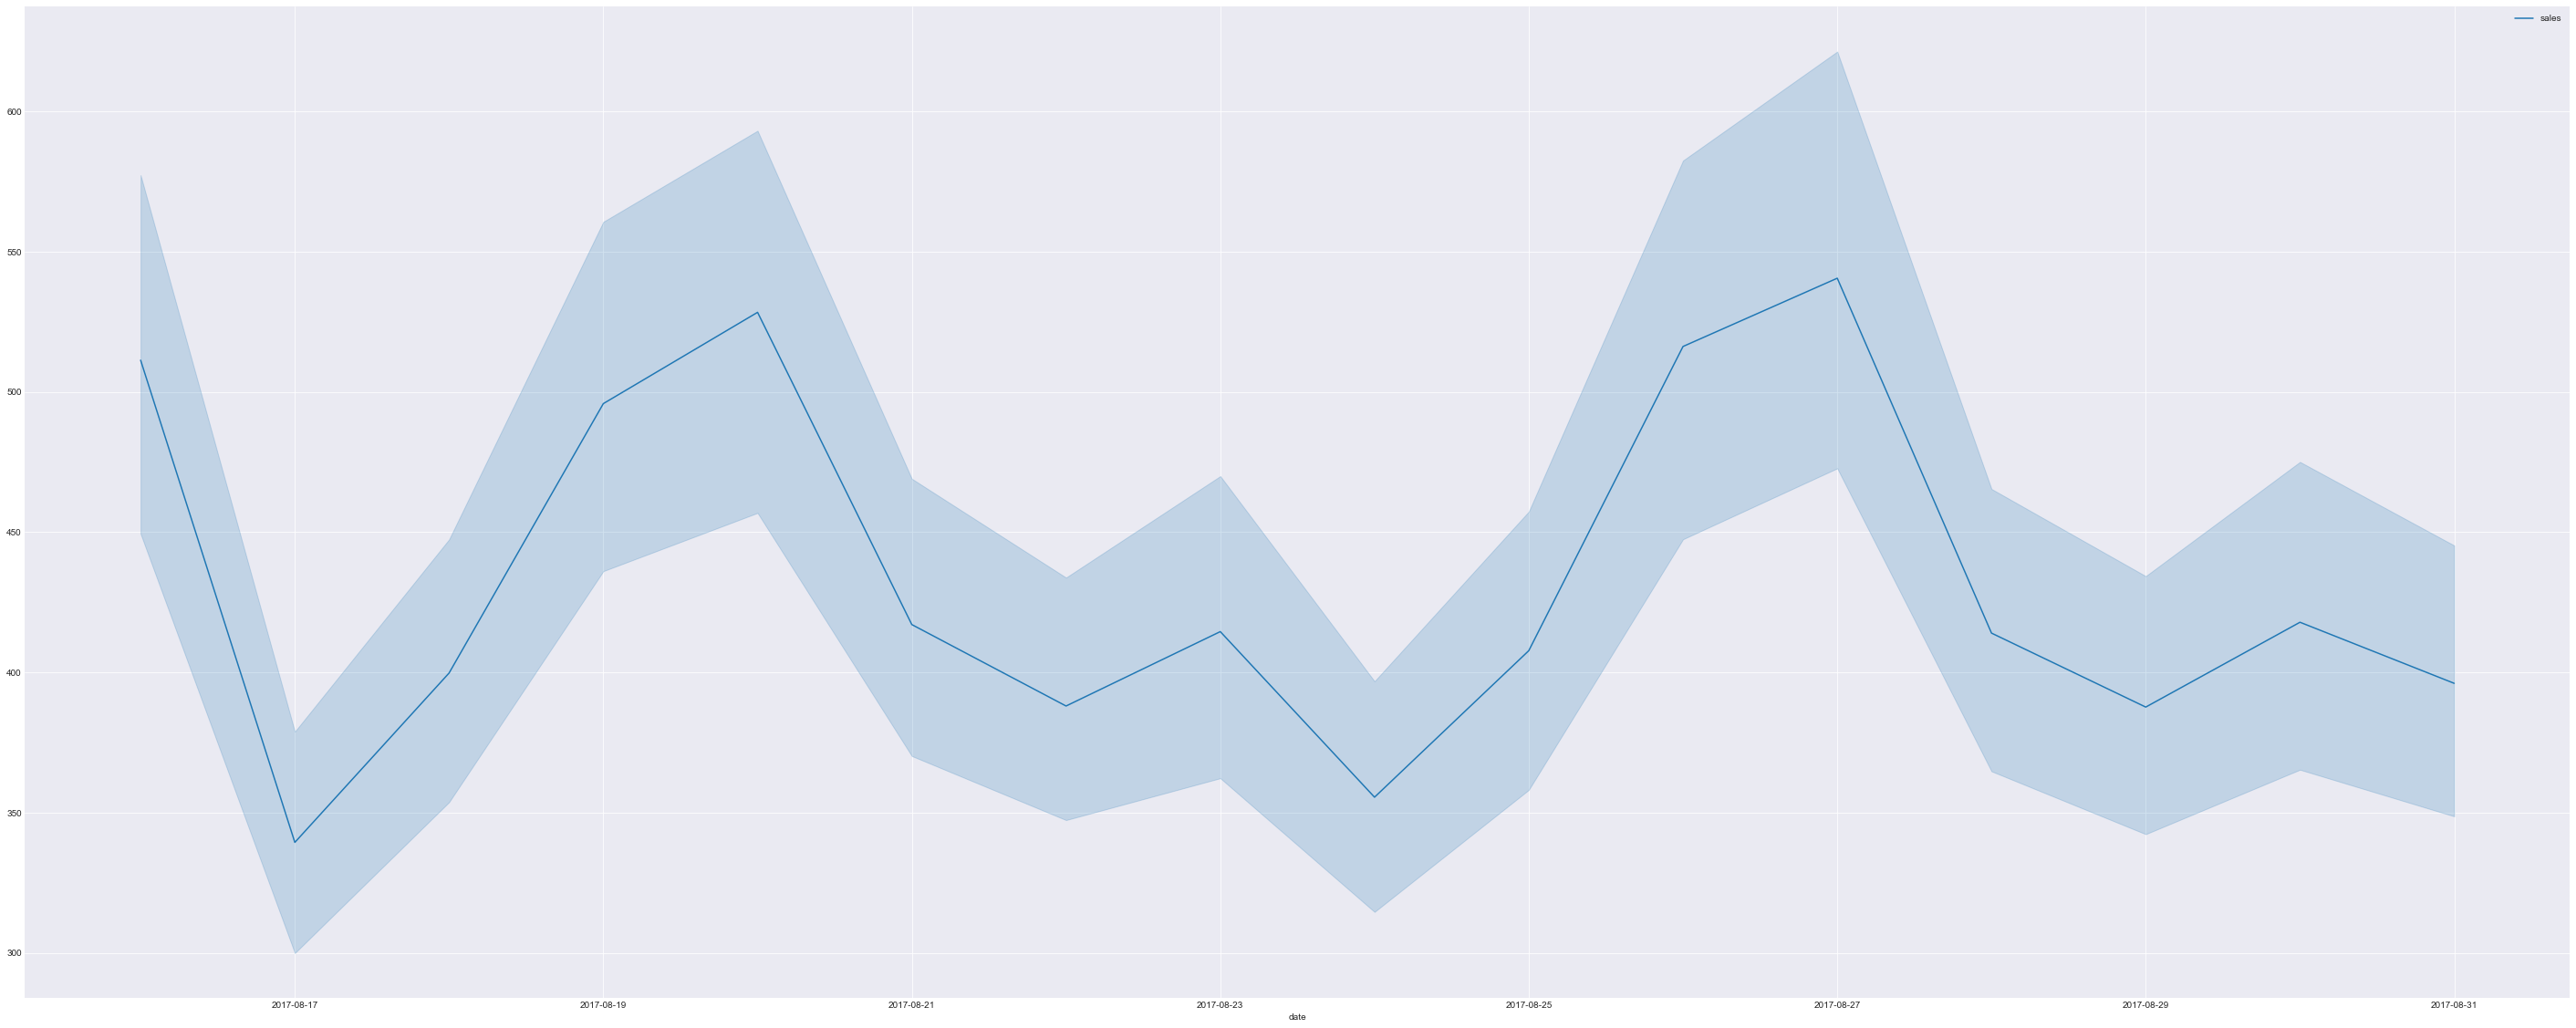

In [55]:
plt.figure(figsize=(50,20))
sb.lineplot(data=temp)
plt.show()
